# Heart Disease Prediction — CI Module Assignment

This notebook builds a **deep learning classifier** to predict the presence of heart disease from clinical features.

### Workflow
1. Data Loading & Initial Inspection
2. Data Cleaning & Imputation
3. Exploratory Data Analysis (EDA)
4. Preprocessing & Train/Validation Split
5. Model Building & Training
6. Training Diagnostics
7. Test Predictions & Submission
8. Model Export
9. Streamlit Web App (Optional Deployment)

## 1. Imports & Configuration

In [2]:
# ── Standard libraries ──────────────────────────────────────────────
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ── Scikit-learn ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ── TensorFlow / Keras ─────────────────────────────────────────────
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# ── Serialisation ──────────────────────────────────────────────────
import joblib

# ── Configuration ──────────────────────────────────────────────────
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU (Colab-friendly)
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

RANDOM_STATE = 42
TEST_SIZE = 0.2
EPOCHS = 20
BATCH_SIZE = 64

print(f"TensorFlow version : {tf.__version__}")
print(f"Random state        : {RANDOM_STATE}")

TensorFlow version : 2.19.0
Random state        : 42


## 2. Data Loading & Initial Inspection

In [3]:
# Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Training set : {train_df.shape[0]} rows × {train_df.shape[1]} cols")
print(f"Test set     : {test_df.shape[0]} rows × {test_df.shape[1]} cols")
train_df.head()

Training set : 630000 rows × 15 cols
Test set     : 270000 rows × 14 cols


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [4]:
# Quick overview: dtypes, non-null counts, memory
print("── Training Data Info ─────────────────────────────")
train_df.info()

print("\n── Missing Values ────────────────────────────────")
print(train_df.isnull().sum())

print("\n── Descriptive Statistics ─────────────────────────")
train_df.describe()

── Training Data Info ─────────────────────────────
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thalliu

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,181865.479132,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,0.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,157499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,314999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,472499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,629999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


## 3. Data Cleaning & Imputation

In [5]:
def impute_missing(df: pd.DataFrame, label: str = "DataFrame") -> pd.DataFrame:
    """Fill missing numeric values with column means."""
    missing_before = df.isnull().sum().sum()
    df = df.fillna(df.mean(numeric_only=True))
    missing_after = df.isnull().sum().sum()
    print(f"[{label}] Missing values: {missing_before} → {missing_after}")
    return df


train_df = impute_missing(train_df, label="Train")
test_df = impute_missing(test_df, label="Test")

# Drop any remaining rows with nulls (e.g. non-numeric columns)
train_df.dropna(inplace=True)

print(f"\nCleaned training set: {train_df.shape[0]} rows × {train_df.shape[1]} cols")

[Train] Missing values: 0 → 0
[Test] Missing values: 0 → 0

Cleaned training set: 630000 rows × 15 cols


## 4. Exploratory Data Analysis (EDA)

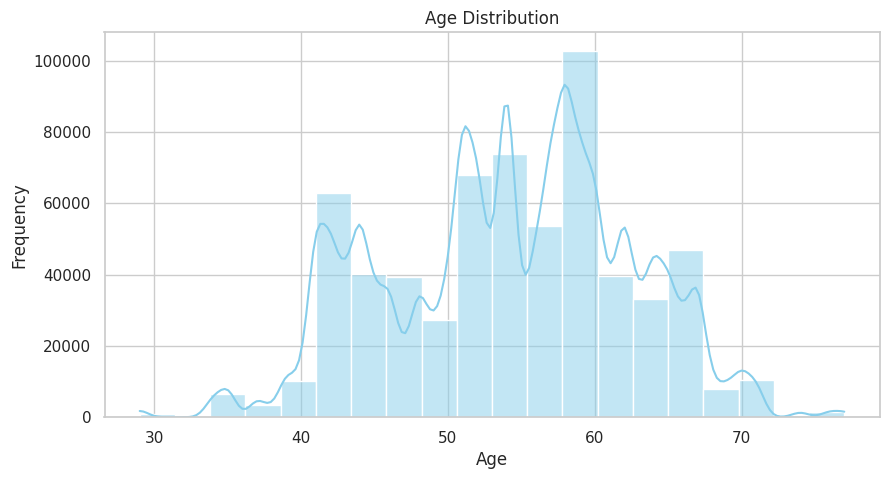

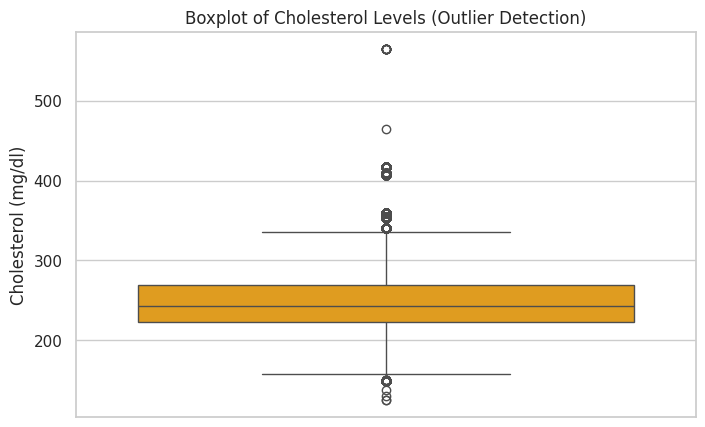

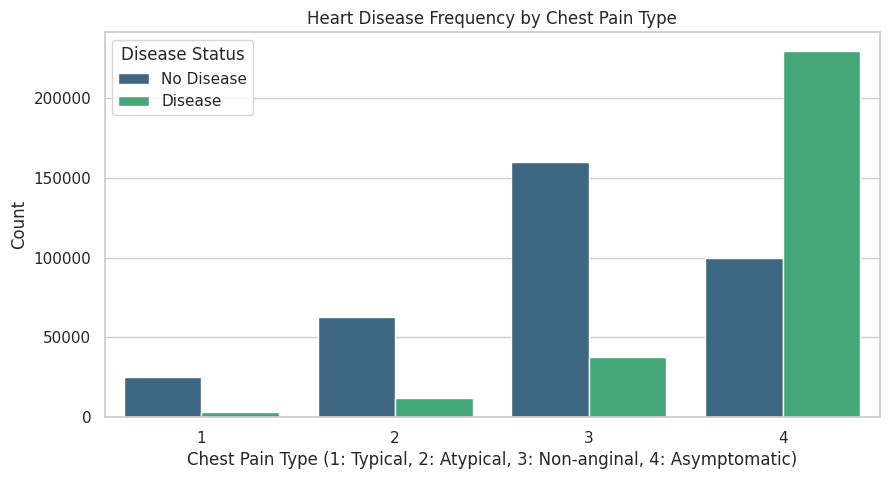

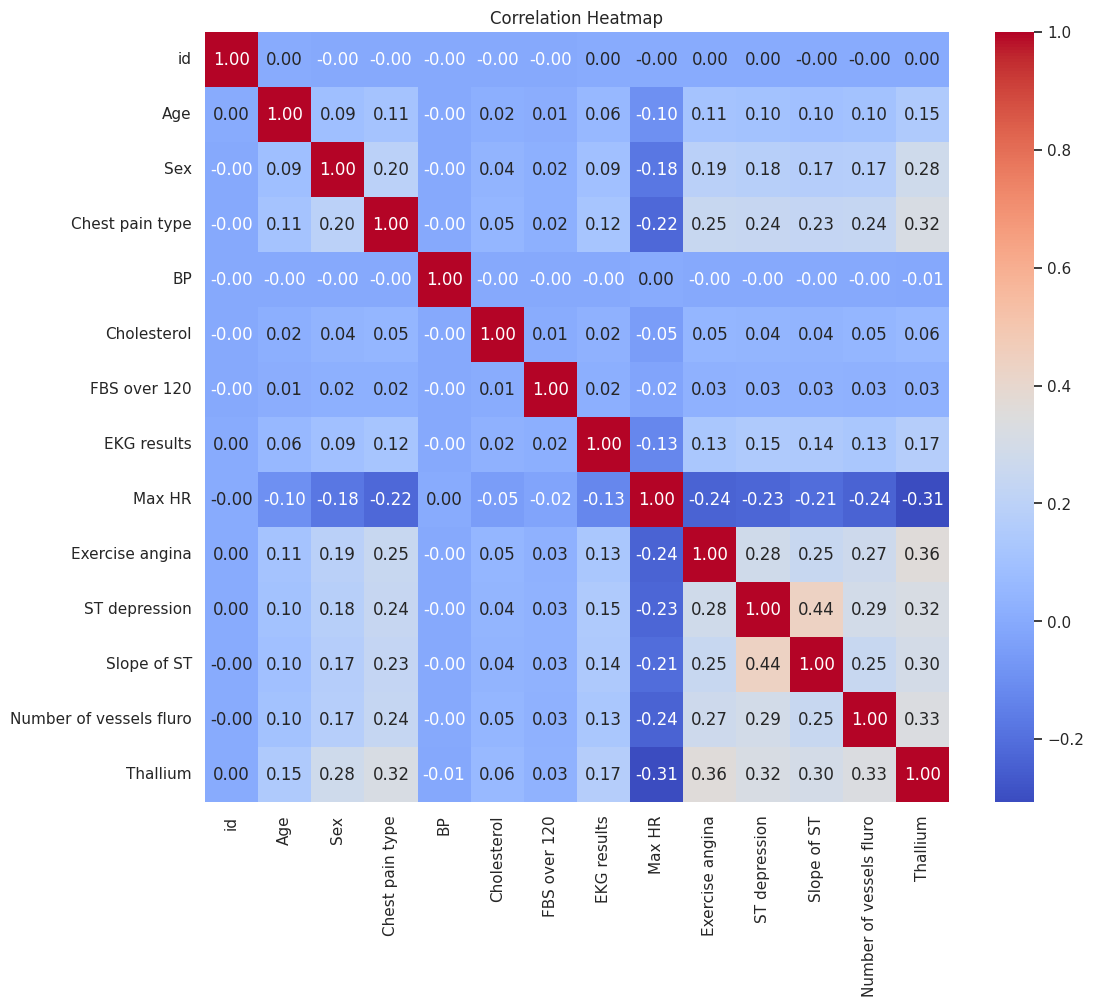

In [6]:
def plot_age_distribution(df: pd.DataFrame) -> None:
    """Histogram of patient ages."""
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x="Age", kde=True, bins=20, color="skyblue")
    plt.title("Age Distribution")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()


def plot_cholesterol_boxplot(df: pd.DataFrame) -> None:
    """Boxplot to detect cholesterol outliers."""
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=df["Cholesterol"], color="orange")
    plt.title("Boxplot of Cholesterol Levels (Outlier Detection)")
    plt.ylabel("Cholesterol (mg/dl)")
    plt.show()


def plot_heart_disease_by_chest_pain(df: pd.DataFrame) -> None:
    """Count plot — heart-disease frequency across chest-pain types."""
    plt.figure(figsize=(10, 5))
    sns.countplot(
        data=df, x="Chest pain type", hue="Heart Disease", palette="viridis"
    )
    plt.title("Heart Disease Frequency by Chest Pain Type")
    plt.xlabel("Chest Pain Type (1: Typical, 2: Atypical, 3: Non-anginal, 4: Asymptomatic)")
    plt.ylabel("Count")
    plt.legend(title="Disease Status", labels=["No Disease", "Disease"])
    plt.show()


def plot_correlation_heatmap(df: pd.DataFrame) -> None:
    """Heatmap of Pearson correlations between numeric features."""
    plt.figure(figsize=(12, 10))
    numeric_df = df.select_dtypes(include=["float64", "int64"])
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()


# ── Run all EDA plots ──────────────────────────────────────────────
plot_age_distribution(train_df)
plot_cholesterol_boxplot(train_df)
plot_heart_disease_by_chest_pain(train_df)
plot_correlation_heatmap(train_df)

## 5. Preprocessing & Train / Validation Split

In [7]:
def prepare_data(
    df: pd.DataFrame,
    target_col: str = "Heart Disease",
    id_col: str = "id",
    test_size: float = TEST_SIZE,
    random_state: int = RANDOM_STATE,
):
    """Encode the target, split features/labels, and scale."""
    # Encode target: "Presence" → 1, "Absence" → 0
    df[target_col] = df[target_col].apply(lambda x: 1 if x == "Presence" else 0)

    X = df.drop(columns=[id_col, target_col])
    y = df[target_col]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    return X_train_scaled, X_val_scaled, y_train, y_val, scaler


X_train_scaled, X_val_scaled, y_train, y_val, scaler = prepare_data(train_df)

print(f"Training features  : {X_train_scaled.shape}")
print(f"Validation features: {X_val_scaled.shape}")
print(f"\nTarget distribution (train):\n{y_train.value_counts()}")

Training features  : (504000, 13)
Validation features: (126000, 13)

Target distribution (train):
Heart Disease
0    277982
1    226018
Name: count, dtype: int64


## 6. Model Building & Training

In [8]:
def build_model(input_dim: int) -> Sequential:
    """Create a simple feed-forward neural network for binary classification."""
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(32, activation="relu"),
        Dropout(0.3),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


model = build_model(input_dim=X_train_scaled.shape[1])
model.summary()

print("\nTraining started...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val),
    verbose=1,
)
print("Training finished!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)


Training started...
Epoch 1/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.8756 - loss: 0.3007 - val_accuracy: 0.8839 - val_loss: 0.2808
Epoch 2/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8847 - loss: 0.2794 - val_accuracy: 0.8844 - val_loss: 0.2825
Epoch 3/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8853 - loss: 0.2769 - val_accuracy: 0.8838 - val_loss: 0.2842
Epoch 4/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8849 - loss: 0.2779 - val_accuracy: 0.8843 - val_loss: 0.2817
Epoch 5/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8853 - loss: 0.2768 - val_accuracy: 0.8840 - val_loss: 0.2878
Epoch 6/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8849 - loss: 0.2767 - val_accuracy: 0.8842 - val_loss: 0.2833
Epoch 7/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8858 - loss: 0.2755 - val_accuracy: 0.8847 - val_loss: 0.2835
Epoch 8/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accur

## 7. Training Diagnostics

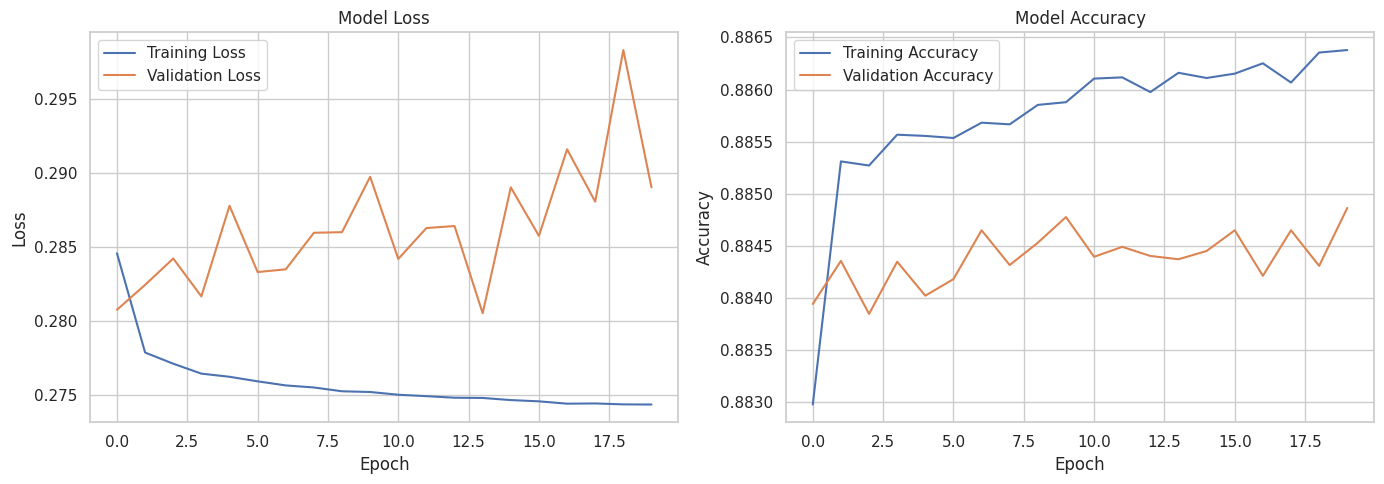

In [9]:
def plot_training_history(history) -> None:
    """Plot training vs validation loss and accuracy."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(history.history["loss"], label="Training Loss")
    axes[0].plot(history.history["val_loss"], label="Validation Loss")
    axes[0].set_title("Model Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Accuracy
    axes[1].plot(history.history["accuracy"], label="Training Accuracy")
    axes[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[1].set_title("Model Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history)

## 8. Test Predictions & Submission File

In [10]:
def generate_submission(
    model,
    scaler: StandardScaler,
    test_df: pd.DataFrame,
    id_col: str = "id",
    threshold: float = 0.5,
    output_path: str = "submission.csv",
) -> pd.DataFrame:
    """Generate a prediction CSV for the held-out test set."""
    test_ids = test_df[id_col]
    X_test = test_df.drop(columns=[id_col]).fillna(0)
    X_test_scaled = scaler.transform(X_test)

    probabilities = model.predict(X_test_scaled)
    binary_preds = (probabilities > threshold).astype(int).flatten()
    label_preds = ["Presence" if p == 1 else "Absence" for p in binary_preds]

    submission = pd.DataFrame({id_col: test_ids, "Heart Disease": label_preds})
    submission.to_csv(output_path, index=False)
    print(f"Submission saved to '{output_path}' ({len(submission)} rows)")
    return submission


submission_df = generate_submission(model, scaler, test_df)
submission_df.head()

8438/8438 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Submission saved to 'submission.csv' (270000 rows)


,id,Heart Disease
0,630000,Presence
1,630001,Absence
2,630002,Presence
3,630003,Absence
4,630004,Absence


## 9. Save Model Artifacts

In [11]:
MODEL_PATH = "heart_model.keras"
SCALER_PATH = "scaler.pkl"

model.save(MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)

print(f"Model  saved → {MODEL_PATH}")
print(f"Scaler saved → {SCALER_PATH}")

Model  saved → heart_model.keras
Scaler saved → scaler.pkl


## 10. Streamlit Web App (Optional Deployment)

The cell below writes a self-contained **Streamlit** app (`app.py`) that loads the saved model and scaler to serve predictions via a browser UI.

> **To run locally:** `streamlit run app.py`
> **On Google Colab:** use the deployment cell that follows.

In [12]:
%%writefile app.py
"""HeartGuard AI — Streamlit prediction app."""

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

# ── Page config ────────────────────────────────────────────────────
st.set_page_config(
    page_title="HeartGuard AI",
    page_icon="\U0001FAC0",
    layout="wide",
    initial_sidebar_state="expanded",
)

# ── Custom CSS ─────────────────────────────────────────────────────
st.markdown("""
<style>
.main { background-color: #0E1117; }
.title-text { font-size: 50px; font-weight: bold; color: #FF4B4B; text-align: center; margin-bottom: 20px; }
.subtitle-text { font-size: 20px; color: #FAFAFA; text-align: center; margin-bottom: 40px; }
.stButton>button { background-color: #FF4B4B; color: white; font-size: 20px; border-radius: 10px;
                   height: 50px; width: 100%; border: none; }
.stButton>button:hover { background-color: #FF0000; color: white; }
.result-box-high { background-color: #3d0e0e; border: 2px solid #ff4b4b; padding: 20px;
                   border-radius: 10px; text-align: center; }
.result-box-low  { background-color: #0e3d18; border: 2px solid #00cc44; padding: 20px;
                   border-radius: 10px; text-align: center; }
</style>
""", unsafe_allow_html=True)

# ── Load artifacts ─────────────────────────────────────────────────
try:
    model = tf.keras.models.load_model("heart_model.keras")
    scaler = joblib.load("scaler.pkl")
except FileNotFoundError:
    st.error("Model files not found. Please ensure 'heart_model.keras' and 'scaler.pkl' are present.")
    st.stop()

# ── Sidebar ────────────────────────────────────────────────────────
with st.sidebar:
    st.image("https://cdn-icons-png.flaticon.com/512/2966/2966486.png", width=100)
    st.title("HeartGuard AI")
    st.write("Deep-learning risk predictor for heart disease based on clinical data.")
    st.markdown("---")
    st.write("**Instructions:**")
    st.write("1. Fill in the patient details accurately.")
    st.write("2. Click **Analyze Risk** to get the prediction.")
    st.markdown("---")
    st.caption("Developed for CI Module Assignment")

# ── Header ─────────────────────────────────────────────────────────
st.markdown('<p class="title-text">\U0001FAC0 Heart Disease Prediction System</p>', unsafe_allow_html=True)
st.markdown('<p class="subtitle-text">Advanced Deep Learning Analysis</p>', unsafe_allow_html=True)

# ── Input form ─────────────────────────────────────────────────────
CP_MAP = {1: "Typical Angina", 2: "Atypical Angina", 3: "Non-anginal Pain", 4: "Asymptomatic"}
EKG_MAP = {0: "Normal", 1: "ST-T Wave Abnormality", 2: "Left Ventricular Hypertrophy"}
SLOPE_MAP = {1: "Upsloping", 2: "Flat", 3: "Downsloping"}
THALLIUM_MAP = {3: "Normal", 6: "Fixed Defect", 7: "Reversable Defect"}

with st.container():
    st.subheader("Patient Information")
    col1, col2, col3 = st.columns(3)

    with col1:
        age = st.number_input("Age (Years)", min_value=1, max_value=120, value=50)
        sex = st.selectbox("Sex", options=[1, 0], format_func=lambda x: "Male" if x == 1 else "Female")
        cp = st.selectbox("Chest Pain Type", options=list(CP_MAP), format_func=CP_MAP.get)

    with col2:
        bp = st.number_input("Resting Blood Pressure (mm Hg)", min_value=50, max_value=250, value=120)
        chol = st.number_input("Cholesterol (mg/dl)", min_value=100, max_value=600, value=200)
        fbs = st.selectbox("Fasting Blood Sugar > 120 mg/dl", options=[1, 0],
                           format_func=lambda x: "True" if x == 1 else "False")

    with col3:
        max_hr = st.number_input("Max Heart Rate Achieved", min_value=50, max_value=250, value=150)
        ex_angina = st.selectbox("Exercise Induced Angina", options=[1, 0],
                                 format_func=lambda x: "Yes" if x == 1 else "No")
        ekg = st.selectbox("Resting EKG Results", options=list(EKG_MAP), format_func=EKG_MAP.get)

    st.markdown("---")
    st.subheader("Advanced Clinical Metrics")
    col4, col5, col6 = st.columns(3)

    with col4:
        oldpeak = st.number_input("ST Depression (Oldpeak)", value=0.0, step=0.1)
    with col5:
        slope = st.selectbox("Slope of ST Segment", options=list(SLOPE_MAP), format_func=SLOPE_MAP.get)
    with col6:
        vessels = st.selectbox("Number of Major Vessels (0-3)", options=[0, 1, 2, 3])
        thallium = st.selectbox("Thallium Stress Test", options=list(THALLIUM_MAP),
                                format_func=THALLIUM_MAP.get)

# ── Prediction ─────────────────────────────────────────────────────
st.markdown("<br>", unsafe_allow_html=True)

if st.button("Analyze Risk"):
    input_data = pd.DataFrame({
        "Age": [age], "Sex": [sex], "Chest pain type": [cp], "BP": [bp],
        "Cholesterol": [chol], "FBS over 120": [fbs], "EKG results": [ekg],
        "Max HR": [max_hr], "Exercise angina": [ex_angina], "ST depression": [oldpeak],
        "Slope of ST": [slope], "Number of vessels fluro": [vessels], "Thallium": [thallium],
    })

    input_scaled = scaler.transform(input_data)
    prob = model.predict(input_scaled)[0][0]
    prediction = int(prob > 0.5)
    confidence = prob if prediction == 1 else 1 - prob

    st.markdown("---")
    st.markdown("<h2 style='text-align: center;'>Analysis Result</h2>", unsafe_allow_html=True)

    _, center, _ = st.columns([1, 2, 1])
    with center:
        if prediction == 1:
            st.markdown(f"""
            <div class="result-box-high">
                <h2 style="color: #ff4b4b;">WARNING — HIGH RISK DETECTED</h2>
                <p style="font-size:18px; color:white;">The model predicts a high probability of heart disease.</p>
                <p style="font-size:24px; font-weight:bold; color:white;">Confidence: {confidence*100:.2f}%</p>
            </div>""", unsafe_allow_html=True)
        else:
            st.markdown(f"""
            <div class="result-box-low">
                <h2 style="color: #00cc44;">LOW RISK DETECTED</h2>
                <p style="font-size:18px; color:white;">The model predicts a low probability of heart disease.</p>
                <p style="font-size:24px; font-weight:bold; color:white;">Confidence: {confidence*100:.2f}%</p>
            </div>""", unsafe_allow_html=True)

Writing app.py


### Deploy on Google Colab (via Cloudflare Tunnel)

Run the cell below **only** when executing inside Google Colab.  
It installs Streamlit, starts the app, and exposes it through a Cloudflare quick-tunnel.

In [13]:
# ⚠️  Run this cell ONLY on Google Colab
import subprocess, time

# Kill any stale processes
!pkill -f streamlit  2>/dev/null || true
!pkill -f cloudflared 2>/dev/null || true

# Install Streamlit if needed
!pip install streamlit -q

# Start Streamlit in the background
print("Starting Streamlit app ...")
proc = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.headless", "true"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
time.sleep(5)

# Download cloudflared binary and open a tunnel
!wget -q -nc https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
!./cloudflared-linux-amd64 tunnel --url http://localhost:8501

^C
^C
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 81.9 MB/s eta 0:00:00
Starting Streamlit app ...
2026-02-08T05:37:28Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-02-08T05:37:28Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-02-08T05:37:31Z INF +--------------------------------------------------------------------------------------------+
2026-02-08T05: